In [11]:
import numpy as np, os, sys
sys.path.append("..")

import torch
from torch import nn
from torch.nn import functional as F 

from src.utils.synthetic_seqdata import download_data, load_data, sequence_string_to_one_hot
from src.models.deepbind_cnn import BasicCNN
from src.trainer.trainer import Trainer
from src.utils.datasets import DNASequenceDataset
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib as mpl 
from matplotlib import pyplot as plt 
%matplotlib inline

In [2]:
# get data 
savedir = "./data"
#_=download_data(savedir)
Xs, Ys = load_data(savedir=savedir)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
# set up datasets
datasets = {}
for k in Xs:
    datasets[k] = DNASequenceDataset(sequences=Xs[k], labels=Ys[k], alphabet="ACGT")

# set up dataloaders 
batch_size = 32
loaders = {}
for k, dataset in datasets.items():
    loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
# set up the model, lossfn, optimizer, trainer 
learning_rate = 1e-3
model = BasicCNN(input_size=4, output_size=1, kernel_size=9)
lossfn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trainer = Trainer(model, lossfn, optimizer)

# fit model
nepochs = 35
history = trainer.fit(loaders['train'], val_loader=loaders['valid'], nepochs=nepochs)

 --- [Epoch   1/35] --- 
loss : 0.8113, val_loss : 0.9712
 --- [Epoch   2/35] --- 
loss : 0.7138, val_loss : 0.7151
 --- [Epoch   3/35] --- 
loss : 0.6992, val_loss : 0.7017
 --- [Epoch   4/35] --- 
loss : 0.7095, val_loss : 0.6966
 --- [Epoch   5/35] --- 
loss : 0.6971, val_loss : 0.7117
 --- [Epoch   6/35] --- 
loss : 0.7077, val_loss : 0.6985
 --- [Epoch   7/35] --- 
loss : 0.6987, val_loss : 0.7048
 --- [Epoch   8/35] --- 
loss : 0.7067, val_loss : 0.6939
 --- [Epoch   9/35] --- 
loss : 0.6982, val_loss : 0.7137
 --- [Epoch  10/35] --- 
loss : 0.7061, val_loss : 0.6959
 --- [Epoch  11/35] --- 
loss : 0.6997, val_loss : 0.7059
 --- [Epoch  12/35] --- 
loss : 0.7053, val_loss : 0.6931
 --- [Epoch  13/35] --- 
loss : 0.6993, val_loss : 0.7149
 --- [Epoch  14/35] --- 
loss : 0.7049, val_loss : 0.6944
 --- [Epoch  15/35] --- 
loss : 0.7008, val_loss : 0.7067
 --- [Epoch  16/35] --- 
loss : 0.7039, val_loss : 0.6929
 --- [Epoch  17/35] --- 
loss : 0.7006, val_loss : 0.7157
 --- [Epoch  1

In [6]:
history

{'loss': [0.8112784740451264,
  0.7138135087544515,
  0.6991538921175482,
  0.7095061454870929,
  0.6971448359151954,
  0.707702053736334,
  0.6986727537629811,
  0.7066837996924848,
  0.6981987504109944,
  0.7060851973213561,
  0.6997003157933553,
  0.7052592263646322,
  0.6993047752881159,
  0.7048795174245965,
  0.7008376808743498,
  0.7039116031775191,
  0.7005617403548602,
  0.7035999601562274,
  0.7021354877785461,
  0.7024436535900587,
  0.7019764593202774,
  0.7022035924811342,
  0.7035487480631702,
  0.7008880503373603,
  0.7034755059301037,
  0.7007620861269024,
  0.7049772362458652,
  0.6993499738440666,
  0.7049415619133814,
  0.6993934841460834,
  0.706287941976225,
  0.6979674077741632,
  0.7062331199918164,
  0.6982375029559549,
  0.7073329345548534],
 'val_loss': [0.9711877334685552,
  0.7151332298914591,
  0.7016915962809608,
  0.6966206317856198,
  0.7117118854371328,
  0.6984876365888686,
  0.704790921438308,
  0.6938783933245947,
  0.7137438626516432,
  0.6959214693

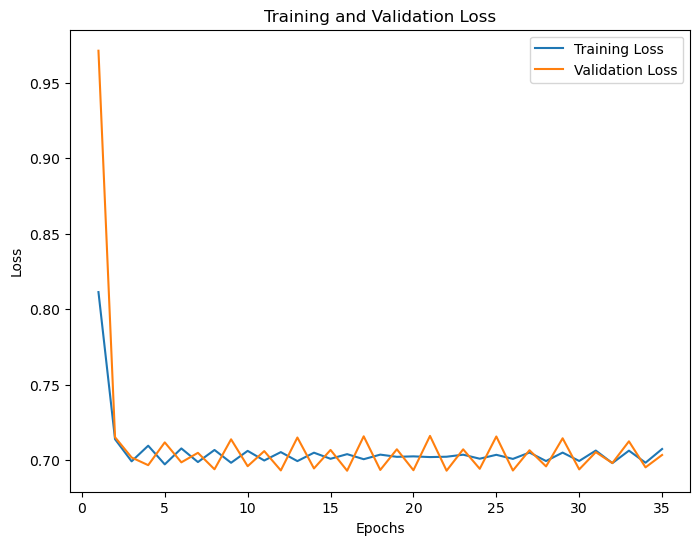

In [10]:
# Calculate AUROC for test predictions
model.eval()
test_scores = []
test_labels = []
with torch.no_grad():
    for inputs, labels in loaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_scores.extend(outputs.cpu().squeeze().tolist())
        test_labels.extend(labels.cpu().tolist())

# Plot training/validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(history['loss'])+1), history['loss'], label='Training Loss')
plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Test AUROC: 0.5000


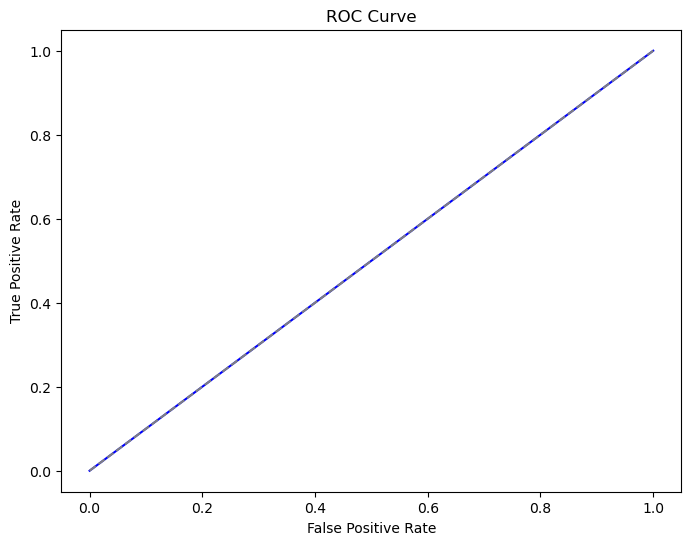

In [12]:
test_auroc = roc_auc_score(test_labels, test_scores)
print(f"Test AUROC: {test_auroc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()